In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
import prototype_GRB_population as pt
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
import miscelaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

# General imports
import yaml
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')

plt.style.use('presentation')

In [2]:
paths_to_dir, paths_to_files = io.generate_paths()

10:27:54.437 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
10:27:54.438 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
10:27:54.439 [DEBUG] File paths :
    'config'  : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'   : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum' : /Users/palmerio/Science_projects/GRB_population_model/init/instruments.yml

In [3]:
config, params, instruments, samples = io.read_init_files(paths_to_files)
paths_to_dir['output'] = '/Users/palmerio/Science_projects/GRB_population_model/model_outputs/best_populations'
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            ECLAIRs_config=instruments['ECLAIRs'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

# Nb_GRBs = int(float(config['Nb_GRBs']))
Nb_GRBs = int(1e6)

incl_samples = msc.included_samples(config['samples'], samples)
incl_instruments = msc.included_instruments(incl_samples, instruments)

10:27:54.744 [DEBUG] Input configuration:
Nb_GRBs: 1e5
likelihood:
    epsilon: 0.001
output_dir: debugger
samples:
- Stern
- EpGBM
- eBAT6
- Swift
- ECLAIRs
- SHOALS
save_all_GRBs: false

10:27:54.747 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: 0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zeta: null
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM_Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47

10:27:54.755 [DEBUG] ==============================================
10:27:54.755 [DEBUG] ===           ECLAIRs instrument           ===
10:27:54.756 [DEBUG] ==============================================
10:27:54.757 [DEBUG] ECLAIRs energy channel: 4.0 t

In [9]:
# Generate the populations for the best model in each scenario or load the populations from files
# WARNING : this takes a long time to compute (at least 30 min with Nb_GRBs = 1e6)
##################

load_files = True

##################


np.random.seed(1)
model_names = ['kF_LN_nSFR',
               'k0_LN_nF', 
               'k05_LN_nF', 
               'k1_LN_nF', 
               'k2_LN_nF', 
               'kF_A_nSFR',
               'k0_A_nF', 
               'k05_A_nF',
               'k05_A_nF_2',
               'k1_A_nF', 
               'k1_A_nF_2', 
               'k2_A_nF']

# model_names = ['k1_LN_nF']
model_names_ks = ['k0_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k2_A_nF']
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']

parameters = {}
dfs = {}
results = {}
for mod in model_names:
    if load_files:
        dfs[mod] = pd.read_parquet(paths_to_dir['output'] + f'/population_{mod}')
    else:
        with open(paths_to_files['param'].parent / f'parameters_{mod}.yml', 'r') as f:
            parameters[mod] = yaml.safe_load(f)

        GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
        GRB_prop = GRB_population.draw_GRB_properties(cosmo=cosmo, params=parameters[mod], run_mode=None)

        ph.calc_peak_photon_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
        ph.calc_peak_energy_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
        ph.calc_photon_fluence(GRB_prop, incl_instruments)
        ph.calc_energy_fluence(GRB_prop, incl_instruments)
        ph.calc_det_prob(GRB_prop, incl_samples, **ECLAIRs_prop)
        dfs[mod] = pd.DataFrame(GRB_prop)

In [5]:
# Save the best populations to avoid recalculating each time
if not load_files:
    for mod in model_names:
        dfs[mod].to_parquet(paths_to_dir['output'] + f'/population_{mod}')

################# kF_LN_nSFR #####################
17:27:00.453 [INFO] Global GRB rate: 1137.9500015101319
17:27:00.491 [INFO]           Stern chi2: 2.5598e+01
17:27:00.491 [INFO]  Stern normalization: 2.7811e-03 yr-1
17:27:00.492 [INFO]  Simulation duration: 3.5957e+02 yr
17:27:00.493 [INFO]            ndot_LGRB: 2.7811e+03 LGRB/yr
17:27:02.055 [WARNING] findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.


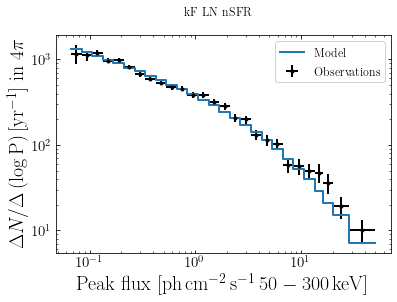

################################################
################# k0_LN_nF #####################
17:27:02.349 [INFO] Global GRB rate: 1137.9500015101319
17:27:02.361 [INFO]           Stern chi2: 3.1422e+01
17:27:02.362 [INFO]  Stern normalization: 9.2986e-03 yr-1
17:27:02.363 [INFO]  Simulation duration: 1.0754e+02 yr
17:27:02.363 [INFO]            ndot_LGRB: 9.2986e+03 LGRB/yr


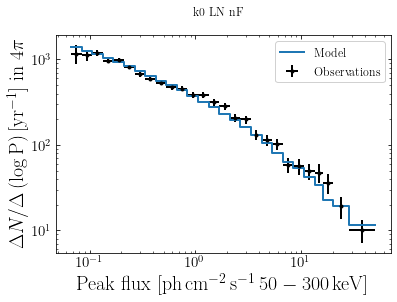

################################################
################# k05_LN_nF #####################
17:27:02.810 [INFO] Global GRB rate: 1137.9500015101319
17:27:02.830 [INFO]           Stern chi2: 2.6268e+01
17:27:02.831 [INFO]  Stern normalization: 5.1089e-03 yr-1
17:27:02.832 [INFO]  Simulation duration: 1.9574e+02 yr
17:27:02.832 [INFO]            ndot_LGRB: 5.1089e+03 LGRB/yr


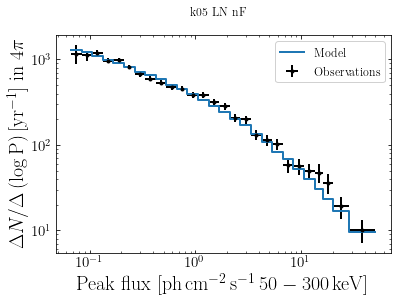

################################################
################# k1_LN_nF #####################
17:27:03.285 [INFO] Global GRB rate: 1137.9500015101319
17:27:03.313 [INFO]           Stern chi2: 2.3651e+01
17:27:03.314 [INFO]  Stern normalization: 3.6214e-03 yr-1
17:27:03.315 [INFO]  Simulation duration: 2.7614e+02 yr
17:27:03.315 [INFO]            ndot_LGRB: 3.6214e+03 LGRB/yr


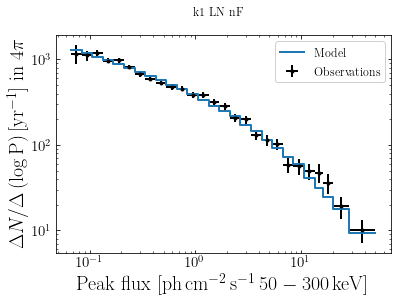

################################################
################# k2_LN_nF #####################
17:27:03.807 [INFO] Global GRB rate: 1137.9500015101319
17:27:03.849 [INFO]           Stern chi2: 2.5278e+01
17:27:03.850 [INFO]  Stern normalization: 2.1816e-03 yr-1
17:27:03.850 [INFO]  Simulation duration: 4.5838e+02 yr
17:27:03.851 [INFO]            ndot_LGRB: 2.1816e+03 LGRB/yr


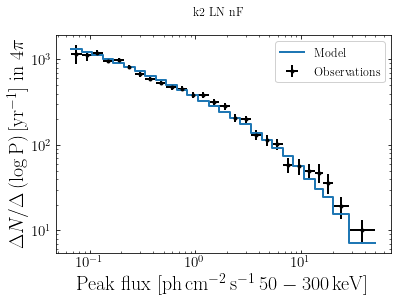

################################################
################# kF_A_nSFR #####################
17:27:04.371 [INFO] Global GRB rate: 1137.9500015101319
17:27:04.423 [INFO]           Stern chi2: 2.9176e+01
17:27:04.424 [INFO]  Stern normalization: 1.9441e-03 yr-1
17:27:04.424 [INFO]  Simulation duration: 5.1439e+02 yr
17:27:04.425 [INFO]            ndot_LGRB: 1.9441e+03 LGRB/yr


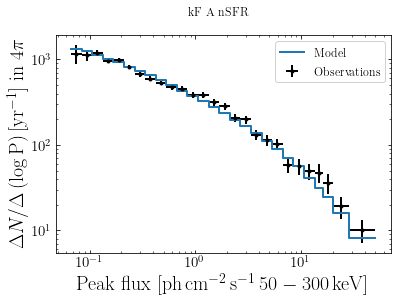

################################################
################# k0_A_nF #####################
17:27:04.942 [INFO] Global GRB rate: 1137.9500015101319
17:27:04.957 [INFO]           Stern chi2: 2.6448e+01
17:27:04.957 [INFO]  Stern normalization: 7.9890e-03 yr-1
17:27:04.958 [INFO]  Simulation duration: 1.2517e+02 yr
17:27:04.959 [INFO]            ndot_LGRB: 7.9890e+03 LGRB/yr


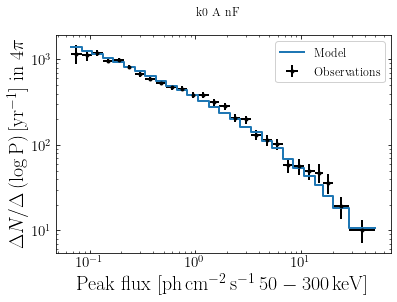

################################################
################# k05_A_nF #####################
17:27:05.435 [INFO] Global GRB rate: 1137.9500015101319
17:27:05.451 [INFO]           Stern chi2: 3.5543e+01
17:27:05.452 [INFO]  Stern normalization: 6.8070e-03 yr-1
17:27:05.452 [INFO]  Simulation duration: 1.4691e+02 yr
17:27:05.453 [INFO]            ndot_LGRB: 6.8070e+03 LGRB/yr


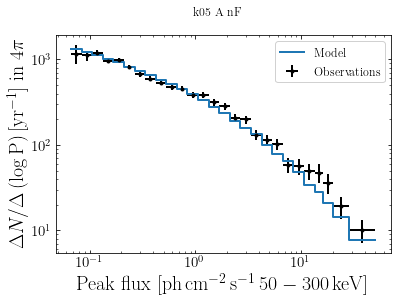

################################################
################# k05_A_nF_2 #####################
17:27:06.006 [INFO] Global GRB rate: 1137.9500015101319
17:27:06.029 [INFO]           Stern chi2: 2.9691e+01
17:27:06.030 [INFO]  Stern normalization: 4.9277e-03 yr-1
17:27:06.031 [INFO]  Simulation duration: 2.0294e+02 yr
17:27:06.031 [INFO]            ndot_LGRB: 4.9277e+03 LGRB/yr


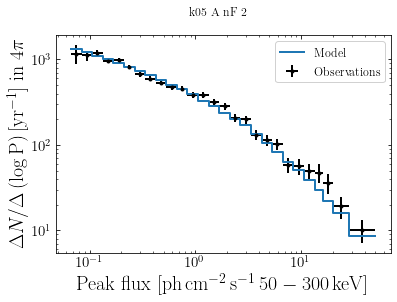

################################################
################# k1_A_nF #####################
17:27:06.550 [INFO] Global GRB rate: 1137.9500015101319
17:27:06.578 [INFO]           Stern chi2: 3.1828e+01
17:27:06.579 [INFO]  Stern normalization: 3.9625e-03 yr-1
17:27:06.579 [INFO]  Simulation duration: 2.5237e+02 yr
17:27:06.580 [INFO]            ndot_LGRB: 3.9625e+03 LGRB/yr


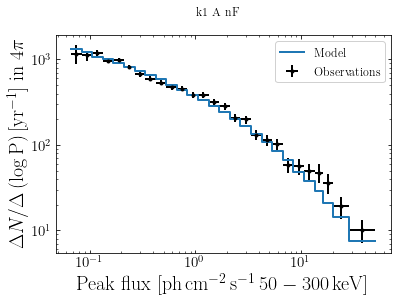

################################################
################# k1_A_nF_2 #####################
17:27:07.195 [INFO] Global GRB rate: 1137.9500015101319
17:27:07.219 [INFO]           Stern chi2: 2.4320e+01
17:27:07.220 [INFO]  Stern normalization: 4.7613e-03 yr-1
17:27:07.220 [INFO]  Simulation duration: 2.1003e+02 yr
17:27:07.221 [INFO]            ndot_LGRB: 4.7613e+03 LGRB/yr


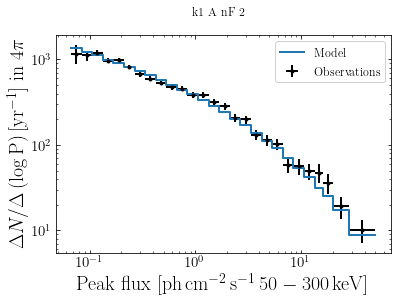

################################################
################# k2_A_nF #####################
17:27:07.784 [INFO] Global GRB rate: 1137.9500015101319
17:27:07.832 [INFO]           Stern chi2: 2.7315e+01
17:27:07.833 [INFO]  Stern normalization: 2.0414e-03 yr-1
17:27:07.834 [INFO]  Simulation duration: 4.8986e+02 yr
17:27:07.834 [INFO]            ndot_LGRB: 2.0414e+03 LGRB/yr


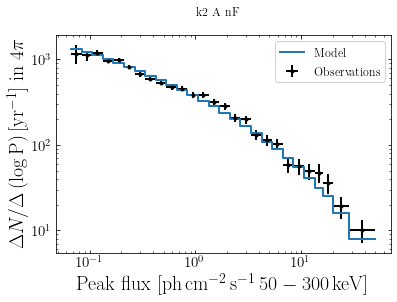

################################################


In [6]:
# Calculate the predicted rate for SVOM/ECLAIRs
sky_frac = ECLAIRs_prop['omega_ECLAIRs_tot'] / (4*np.pi)
for mod in model_names:
    print(f"################# {mod} #####################")
    norm_Stern, mod_Stern = obs.compare_to_Stern(dfs[mod][dfs[mod]['pdet_Stern']==1]['pht_pflx_BATSE'],
                                                 Stern_file=paths_to_dir['obs']/'Stern_lognlogp_rebinned.txt',
                                                 Nb_GRBs=Nb_GRBs, show_plot=True)
    fig = plt.gcf()
    fig.suptitle(mod.replace('_',' '))
    results[mod] = {}
    results[mod]['Tsim'] = 1./norm_Stern
    results[mod]['ndot_LGRB'] = norm_Stern * Nb_GRBs
    results[mod]['ECLAIRs_cts_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_pht_cts']) * norm_Stern * sky_frac
    results[mod]['ECLAIRs_flnc_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_pht_flnc']) * norm_Stern * sky_frac
    results[mod]['ECLAIRs_tot_rate'] = np.sum(dfs[mod]['pdet_ECLAIRs_tot']) * norm_Stern * sky_frac
    plt.show()
    print("################################################")
    
    

################# kF_LN_nSFR #####################
18:33:34.174 [INFO]           EpGBM chi2: 1.3630e+01
18:33:34.174 [INFO]  EpGBM normalization: 1.3185e-02


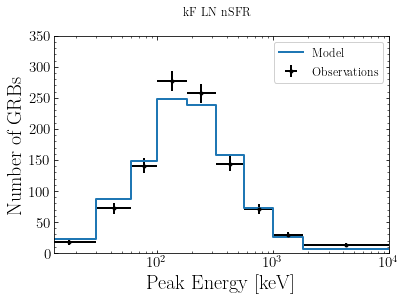

################################################
################# k0_LN_nF #####################
18:33:34.530 [INFO]           EpGBM chi2: 1.0703e+01
18:33:34.531 [INFO]  EpGBM normalization: 4.5920e-02


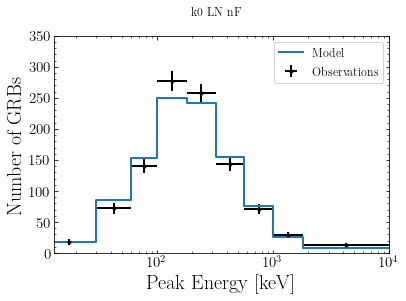

################################################
################# k05_LN_nF #####################
18:33:34.970 [INFO]           EpGBM chi2: 1.0159e+01
18:33:34.971 [INFO]  EpGBM normalization: 2.4445e-02


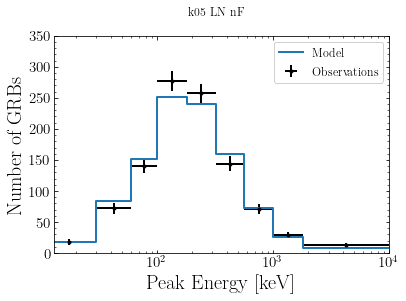

################################################
################# k1_LN_nF #####################
18:33:35.775 [INFO]           EpGBM chi2: 1.0937e+01
18:33:35.775 [INFO]  EpGBM normalization: 1.6747e-02


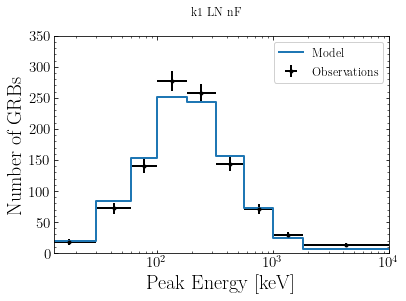

################################################
################# k2_LN_nF #####################
18:33:36.183 [INFO]           EpGBM chi2: 1.2894e+01
18:33:36.184 [INFO]  EpGBM normalization: 1.0388e-02


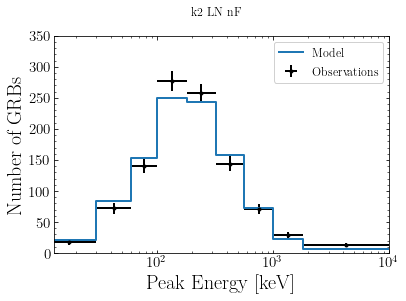

################################################
################# kF_A_nSFR #####################
18:33:36.638 [INFO]           EpGBM chi2: 1.0089e+01
18:33:36.638 [INFO]  EpGBM normalization: 9.4789e-03


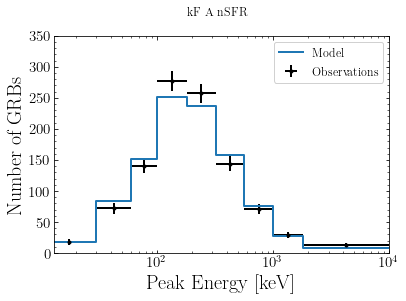

################################################
################# k0_A_nF #####################
18:33:37.012 [INFO]           EpGBM chi2: 1.1923e+01
18:33:37.012 [INFO]  EpGBM normalization: 3.8317e-02


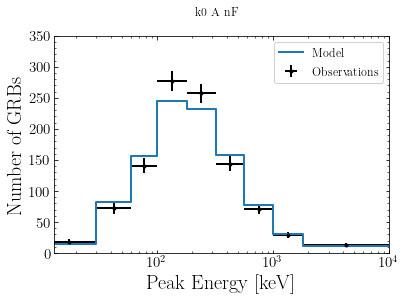

################################################
################# k05_A_nF #####################
18:33:37.376 [INFO]           EpGBM chi2: 2.0971e+01
18:33:37.377 [INFO]  EpGBM normalization: 3.3601e-02


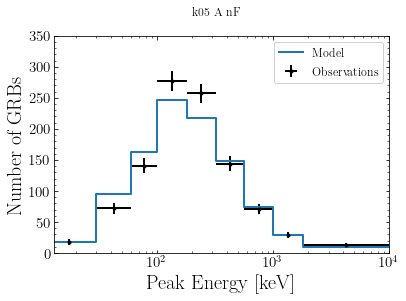

################################################
################# k05_A_nF_2 #####################
18:33:37.741 [INFO]           EpGBM chi2: 1.0145e+01
18:33:37.742 [INFO]  EpGBM normalization: 2.4043e-02


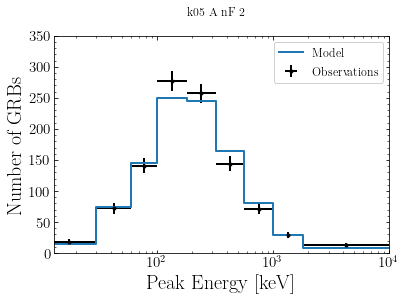

################################################
################# k1_A_nF #####################
18:33:38.392 [INFO]           EpGBM chi2: 1.3124e+01
18:33:38.392 [INFO]  EpGBM normalization: 1.9353e-02


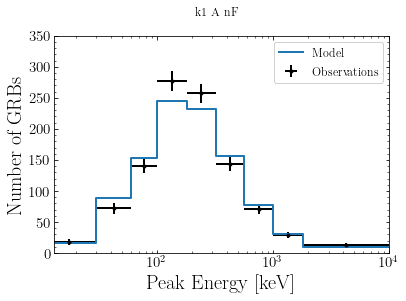

################################################
################# k1_A_nF_2 #####################
18:33:38.998 [INFO]           EpGBM chi2: 1.0925e+01
18:33:38.999 [INFO]  EpGBM normalization: 2.2610e-02


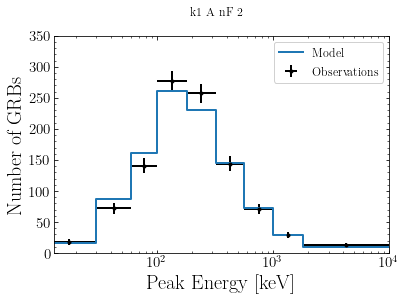

################################################
################# k2_A_nF #####################
18:33:39.420 [INFO]           EpGBM chi2: 1.1694e+01
18:33:39.420 [INFO]  EpGBM normalization: 9.8793e-03


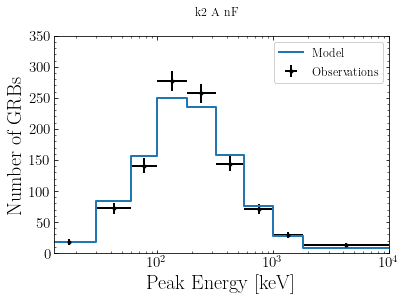

################################################


In [71]:
for mod in model_names:
    print(f"################# {mod} #####################")
    chi2_EpGBM = obs.compare_to_EpGBM(dfs[mod][dfs[mod]['pdet_EpGBM']==1]['Epobs'],
                                      GBM_file=paths_to_dir['obs']/'Ep_GBM_for_plotting.txt',
                                      show_plot=True)
    fig = plt.gcf()
    fig.suptitle(mod.replace('_',' '))
    plt.show()
    print("################################################")
    
    

In [7]:
df_res = pd.DataFrame(results)
df_res

,kF_LN_nSFR,k0_LN_nF,k05_LN_nF,k1_LN_nF,k2_LN_nF,kF_A_nSFR,k0_A_nF,k05_A_nF,k05_A_nF_2,k1_A_nF,k1_A_nF_2,k2_A_nF
Tsim,359.568006,107.543562,195.736184,276.136094,458.375568,514.390049,125.171463,146.906548,202.935130,252.366898,210.028491,489.864401
ndot_LGRB,2781.115073,9298.557529,5108.917418,3621.402710,2181.617149,1944.050048,7989.041426,6807.048523,4927.683051,3962.484818,4761.258806,2041.381241
ECLAIRs_cts_rate,35.517810,36.228037,36.465145,36.265496,35.268898,39.448614,40.561184,47.259723,36.176311,42.077189,49.488399,39.466683
ECLAIRs_flnc_rate,48.786413,50.544171,50.418474,49.460891,48.559040,56.228962,58.588569,71.399722,51.105760,61.299427,74.819796,56.117060
ECLAIRs_tot_rate,50.354023,52.179278,52.037610,51.054372,50.111609,58.118457,60.550336,73.874929,52.817480,63.412562,77.448581,58.007204


################# k0_LN_nF #####################


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


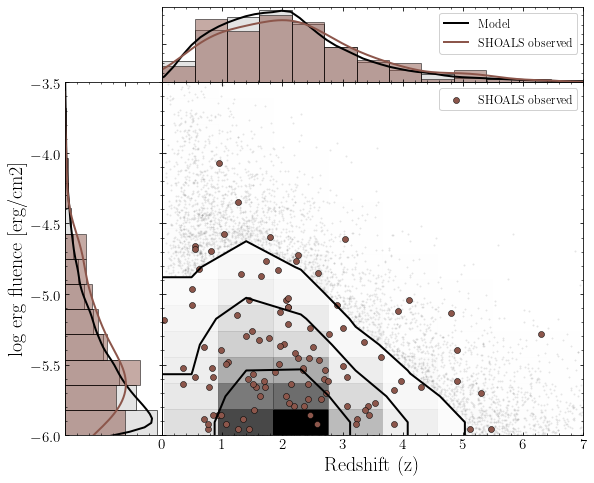

################################################
################# k2_LN_nF #####################


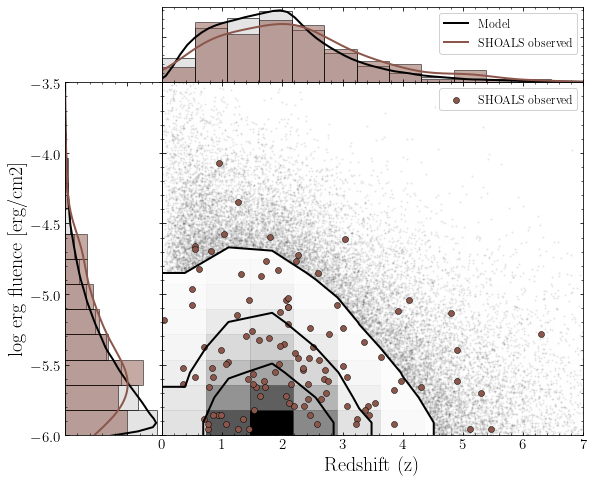

################################################
################# k0_A_nF #####################


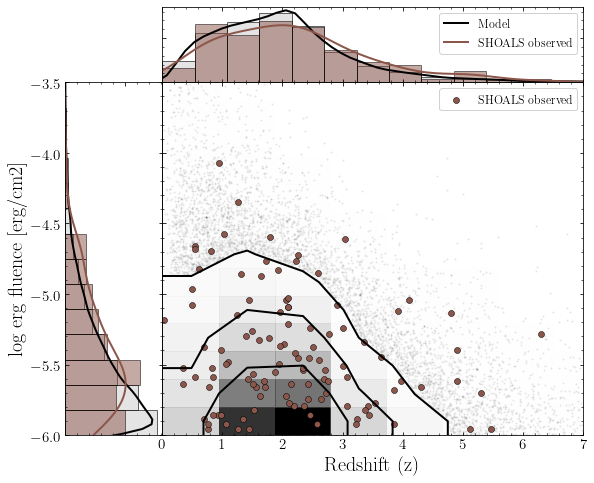

################################################
################# k2_A_nF #####################


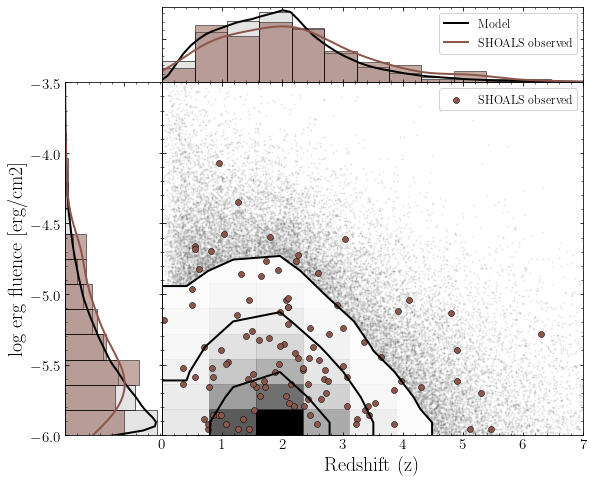

################################################


In [8]:
# This is not very interesting
for mod in model_names_ks:
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_flnc_z_plane(dfs[mod][dfs[mod]['pdet_SHOALS']==1])
    plt.show()
    print("################################################")

################# k0_LN_nF #####################
D-stat, p_value = 0.069, 0.661
################# k2_LN_nF #####################
D-stat, p_value = 0.121, 0.074
################# k0_A_nF #####################
D-stat, p_value = 0.088, 0.352
################# k2_A_nF #####################
D-stat, p_value = 0.108, 0.147


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


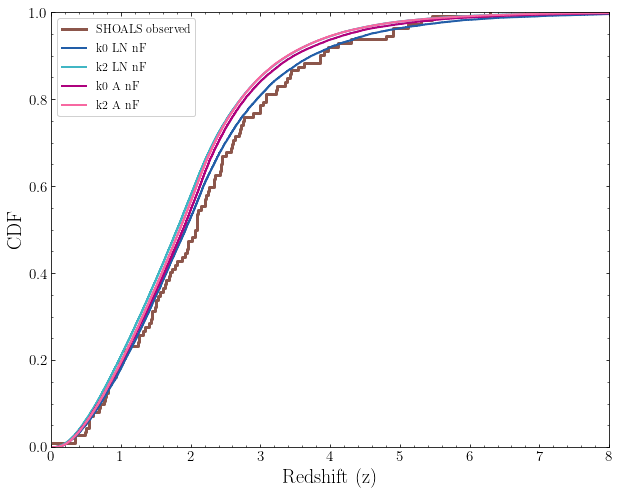

In [9]:
# Plot the redshift distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these redshift distributions and the observed SHOALS redshift distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=(i==0),
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'], df_obs['z'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

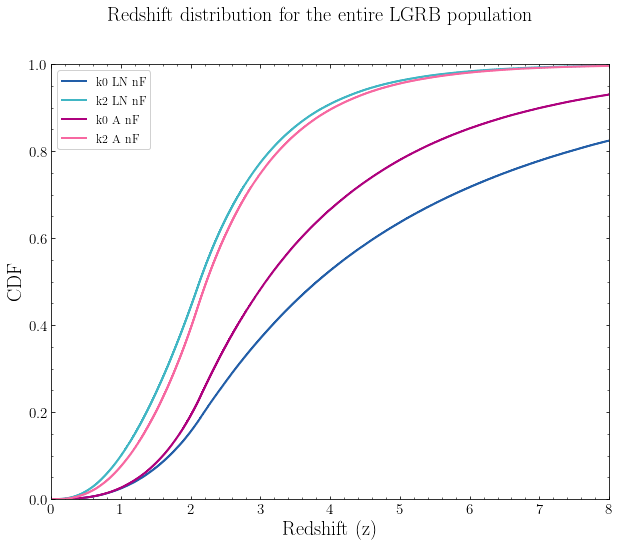

In [10]:
# Since all the redshift distribution of SHOALS look the same, I looked at the redshift distribution
# of the whole LGRB population, which is plotted below
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Redshift distribution for the entire LGRB population', **{'size':20})
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    obs.plot_SHOALS_distr(dfs[mod]['z'], key='z', plot_obs=False,
                            cumul=True, fig=fig, mod_color=colors[i], mod_label=mod.replace('_',' '))

17:27:29.796 [INFO] Subsampling done in 1.193 s
17:27:47.547 [INFO] KS calculations done in 17.750 s
17:27:58.563 [INFO] CDF calculation done in 11.015 s


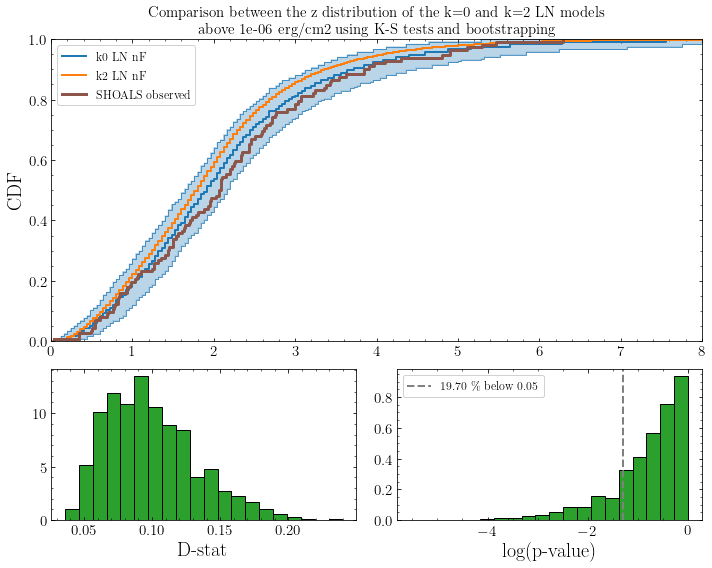

In [11]:
# Clearly the sample size and fluence cut of SHOALS don't allow us to discriminate between k=0 and k=2 models
# What fluence cut and sample size is needed to discriminate between k=0 and k=2 models?
# To answer this we create subsamples of size N_SHOALS=117 from the k=0 redshift distribution and compute
# the K-S test between these subsamples and the entire k=2 sample.
# This is repeated N_bs times (bs stands for bootstrap) to get an idea of how robust the results are.
# For each subsample we compute the K-S test and obtain the D-statistic and the p-value for that realization.
# The resulting distributions of D-statistics and p-values and shown in the bottom panels of the figure
# The top panel shows the CDF and the confidence bounds around it are calculated from the bootstrapping as well.
# The fraction of bootstrap samples that have p-value below 0.05 is shown in the legend of the bottom right panel
N_bs = 1000
N_sub = 117
thrsh = 1e-6
precision=500
st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample2=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:28:04.264 [INFO] Subsampling done in 2.672 s
17:28:07.480 [INFO] KS calculations done in 3.215 s
17:28:09.534 [INFO] CDF calculation done in 2.054 s


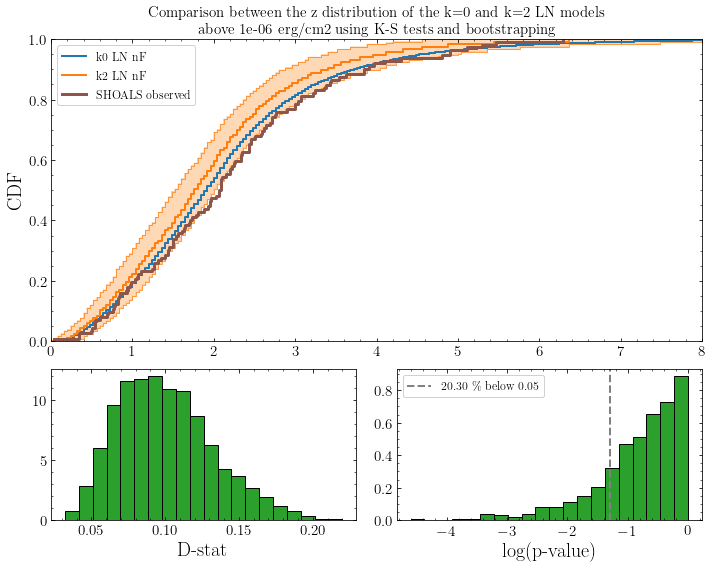

In [12]:
# The following is to show that the results don't change if we subsample from the k=2 scenario instead
# and compare with the entire k=0 redshift distribution.
st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 LN nF',
                 label2='k2 LN nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 LN models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:29:23.104 [INFO] Subsampling done in 14.481 s
17:29:45.986 [INFO] KS calculations done in 22.882 s
17:29:59.928 [INFO] CDF calculation done in 13.941 s


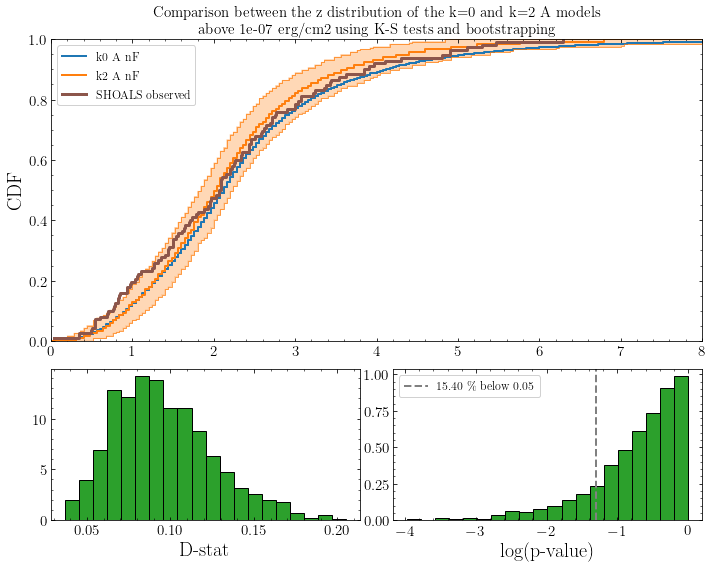

In [14]:
# Here we do the same thing but with the Amati-like scenarios
N_bs = 1000
N_sub = 117
thrsh = 1e-7
precision=500
st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

17:31:14.635 [INFO] Subsampling done in 30.914 s
17:32:16.941 [INFO] KS calculations done in 62.305 s
17:33:00.156 [INFO] CDF calculation done in 43.215 s


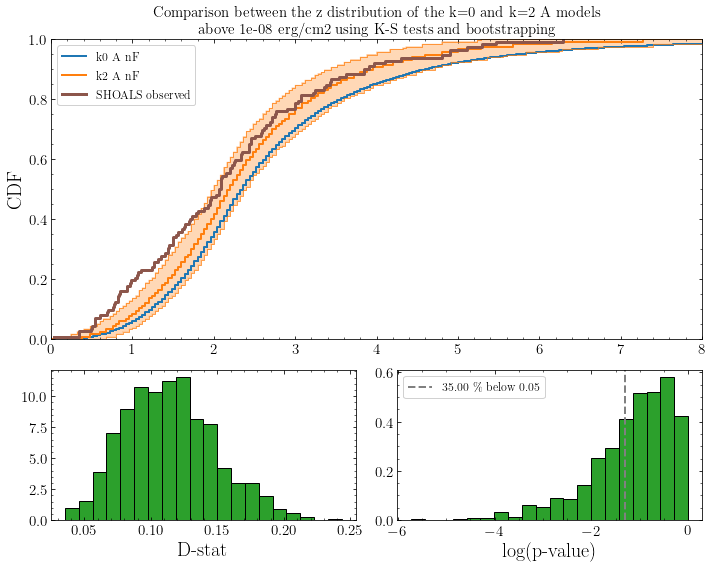

In [16]:
# It seems it is much harder to discriminate between the k=0 and k=2 models, even at deep fluence cuts for the
# Amati-like scenarios
thrsh = 1e-8
st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=thrsh)],
                 dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 label1='k0 A nF',
                 label2='k2 A nF',
                 show_plot=True, subsample1=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,8)
obs.plot_observed_SHOALS_z_distr(axes[0], color='C5', lw=3, label='SHOALS observed')
axes[0].legend()
axes[0].set_title('Comparison between the z distribution of the k=0 and k=2 A models\n above\
              {:.0e} erg/cm2 using K-S tests and bootstrapping'.format(thrsh), **{'size':15})
plt.show()

In [17]:
# Now we want to explore the fluence cut vs sample size plane and see what is required to discriminate
# between k=0 and k=2. We create two arrays for the fluence cuts and the sample size we reasonably expect
# can be obtained and compute the fraction of bootstrap samples that have a p-value below 0.05
# We associate this fraction with the probability of discriminating between the k=0 and k=2 scenarios at the
# 95% confidence level.
flnc_cuts = np.array([1.8e-6, 1e-6, 5.6e-7, 3.2e-7, 1.8e-7, 1e-7])
size = np.array([100, 178, 316, 562, 1000])
p_discr_z = {}
p_discr_L = {}
if load_files:
    for mod in ['LN','LN2','A','A2']:
        try:
            p_discr_z[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}').to_numpy()
            p_discr_L[mod] = pd.read_parquet(paths_to_dir['output']+ f'/p_discr_L_{mod}').to_numpy()
        except Exception:
            pass

In [18]:
# WARNING: long computing time (at least 10 min)
# This is for the LogNormal models
precision=500
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{}% Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN'] = frac

In [19]:
# WARNING: long computing time (at least 10 min)
# This is to check that results don't depend on whether we're subsampling from k=0 or k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_LN_nF'][(dfs['k0_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         dfs['k2_LN_nF'][(dfs['k2_LN_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                         key='z',
                         precision=precision,
                         bins=np.linspace(0,20,precision+1),
                         N_sub=size[i],
                         N_bs=1000,
                         subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['LN2'] = frac

In [20]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample1=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A2'] = frac

In [21]:
# WARNING: long computing time (at least 10 min)
# Same thing with Amati-like scenarios subsampling from k=0 instead of k=2
if not load_files:
    frac = np.zeros((len(size), len(flnc_cuts)))
    k=0
    for i, j in product(range(len(size)), range(len(flnc_cuts))):
        log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
        frac[i,j]= st.subsample_and_KS(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])],
                                     key='z',
                                     precision=precision,
                                     bins=np.linspace(0,20,precision+1),
                                     N_sub=size[i],
                                     N_bs=1000,
                                     subsample2=False)
        log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
        k+=1
    p_discr_z['A'] = frac

In [22]:
def plot_fluence_cut_vs_sample_size(size, flnc_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_flnc_cuts_2D = np.meshgrid(np.log10(size), np.log10(flnc_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_flnc_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(flnc_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(flnc_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(flnc_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Fluence cut [erg/cm$^2$]")
    return

LN


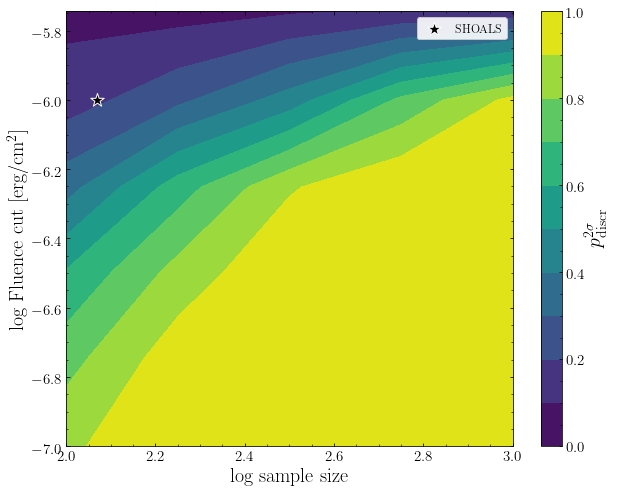

A


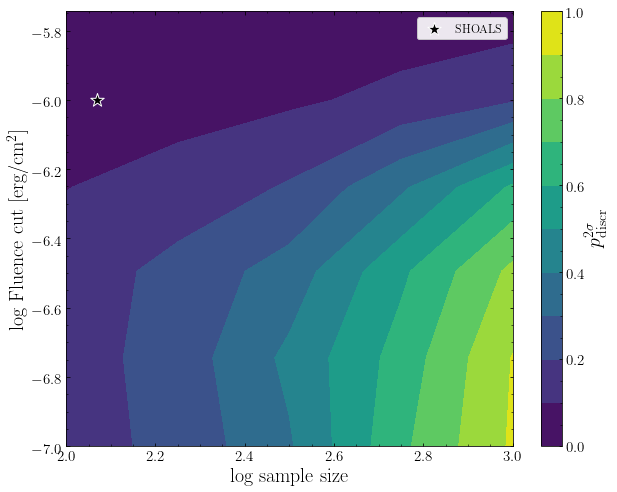

In [23]:
# Create the 2D plane 'fluence cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
for key, value in p_discr_z.items():
    print(key)
    plot_fluence_cut_vs_sample_size(size, flnc_cuts, value)
    ax = plt.gca()
    ax.scatter(np.log10(117), -6, s=200, marker='*', edgecolor='w', color='k', label='SHOALS')
    ax.legend(loc='best')
    plt.show()

In [24]:
# Turn the data into DataFrames and save them
if not load_files:
    for mod, frac in p_discr_z.items():
        df_temp = pd.DataFrame(data=frac, index=size.astype(str), columns=flnc_cuts.astype(str))
        df_temp.to_parquet(paths_to_dir['output']+ f'/p_discr_z_{mod}')


In [13]:
def plot_obs_property(fname, key, func=None,  ax=None, log=False, kde=True, header=2, verbose=False, debug=False, **kwargs):
    """
        Convenience function to quickly plot an observed sample from a given file name.
        A function to filter or cut the sample can be passed as func.
    """
    # Read the entire file
    df_obs = pd.read_csv(fname, sep='|', header=header, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    # Activate verbose to check the column names
    if debug:
        for i,col in enumerate(df_obs.columns):
            print(i,col)
    if func is None:
        df_prop = pd.to_numeric(df_obs[key], errors='coerce')
    else:
        df_prop = func(df_obs, key)

    if log:
        df_prop = np.log10(df_prop)
    if verbose:
        print("Sample size :{}".format(len(df_prop)))
    if ax is None:
        ax = plt.gca()
        
    ax.hist(df_prop, **kwargs)
    if kde:
        sns.kdeplot(df_prop, ax=ax, color='k', linewidth=2, label='KDE')
    return

def filter_EpGBM_obs(df, key, pflx_min=0.9):
    """
        Filter the sample following the criteria for the EpGBM sample:
            - Complete; i.e. pflx [50-300 keV] > 0.9 ph/cm2/s
            - Long; i.e. T90 > 2s
    """
    for k in ['pflx_band_phtfluxb', 't90', key]:
        df[k] = pd.to_numeric(df[k], errors='coerce')
    t90_condition = (df['t90'] >= 2)
    pflx_condition = (df['pflx_band_phtfluxb'] >= pflx_min)
    final_mask = t90_condition & pflx_condition
    df_out = df[final_mask][key].copy()
    return df_out

def filter_Swift_obs(df, key, pflx_min=2):
    """
        Filter the sample following :
            - Peak flux cut; i.e. pflx [15-150 keV] > 1.0 ph/cm2/s
            - Long; i.e. T90 > 2s
    """
    for k in ['bat_peakfluxp', 'bat_t90', key]:
        df[k] = pd.to_numeric(df[k], errors='coerce')
    t90_condition = (df['bat_t90'] >= 2)
    pflx_condition = (df['bat_peakfluxp'] >= pflx_min)
    final_mask = t90_condition & pflx_condition
    df_out = df[final_mask][key].copy()
    return df_out

Sample size :1313
Sample size :629


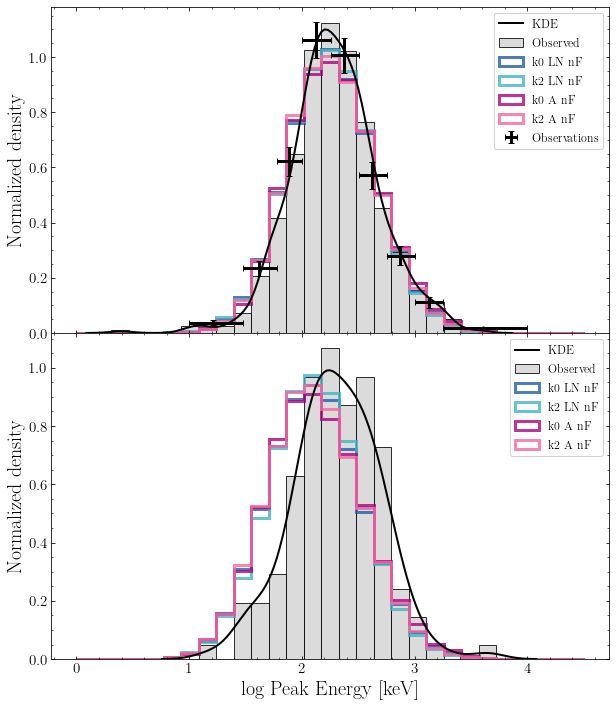

In [15]:
# Now look at Ep-L plane and Ep distributions of various observed samples to try to distinguish between
# Amati-like (intrinsic correlation) scenarios and LogNormal scenarios
bins = np.linspace(0,4.5, 30)
fig, axes = plt.subplots(2, figsize=(10,12))
ax = axes[0]
ax2 = axes[1]
plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=filter_EpGBM_obs,
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax, density=True, label='Observed', alpha=0.8,
                  color='lightgray')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pdet_EpGBM'] == 1
    ax.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))

# Plot Observational constraints

ax.set_ylabel(r'Normalized density')
ax.legend()



plot_obs_property('../catalogs/Swift_cat/Swift_cat_complete.txt',
                  key='bat_epeak',
                  func=filter_Swift_obs,
                  log=True, verbose=True, kde=True,
                  bins=bins,
                  ax=ax2, density=True, label='Observed', alpha=0.8,
                  color='lightgray')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 2
    ax2.hist(np.log10(dfs[mod][cond]['Epobs']), alpha=0.8, density=True,
            bins=bins, color=colors[i], histtype='step', linewidth=3, label=mod.replace('_',' '))


fig.subplots_adjust(hspace=0)
ax2.set_xlabel(r'log Peak Energy $\rm{[keV]}$')
ax2.set_ylabel(r'Normalized density')
ax2.legend()

plt.show()



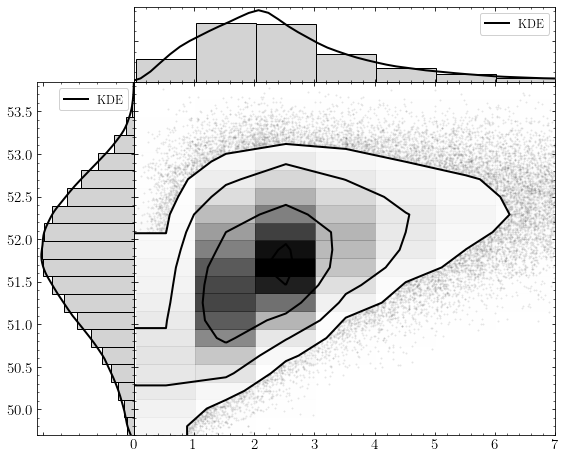

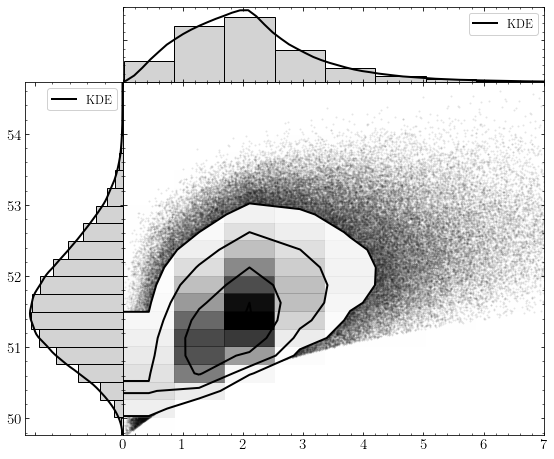

16:31:42.189 [INFO] 0.0 %. Size, fluence cut = 1000 1e-07
16:31:44.457 [INFO] Subsampling done in 0.678 s
16:31:52.942 [INFO] KS calculations done in 8.484 s
16:31:58.554 [INFO] CDF calculation done in 5.611 s
16:31:58.633 [WARNING] No handles with labels found to put in legend.
16:31:58.641 [WARNING] No handles with labels found to put in legend.
16:31:58.694 [INFO] Fraction of samples different at the 95% confidence level : 0.49
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
################# k2_A_nF #####################
D-stat, p_value = 0.073, 0.581
################# k0_LN_nF #####################
D-stat, p_value = 0.072, 0.610
################# k2_LN_nF #####################
D-stat, p_value = 0.076, 0.541
################# k0_A_nF #####################
D-stat, p_value = 0.066, 0.708
########

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


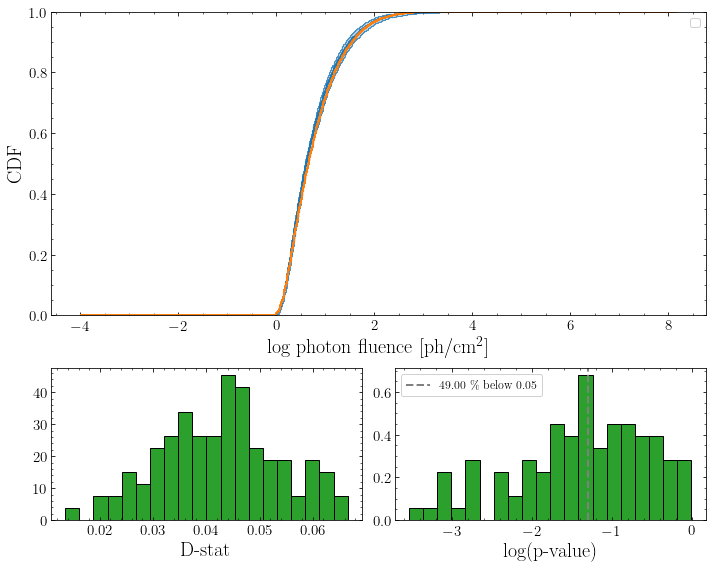

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


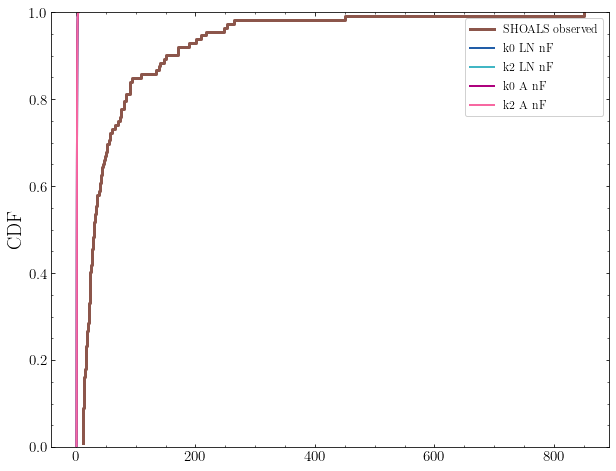

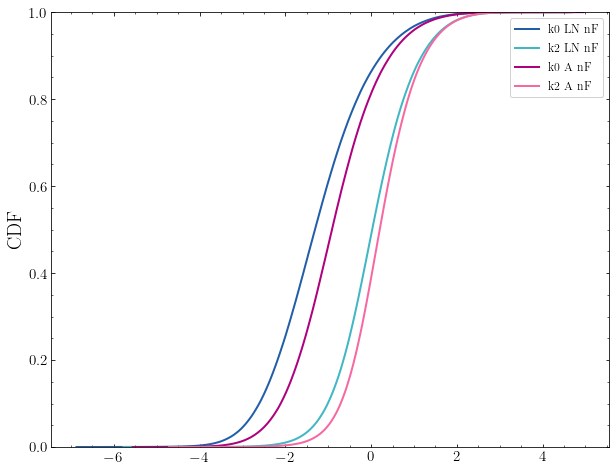

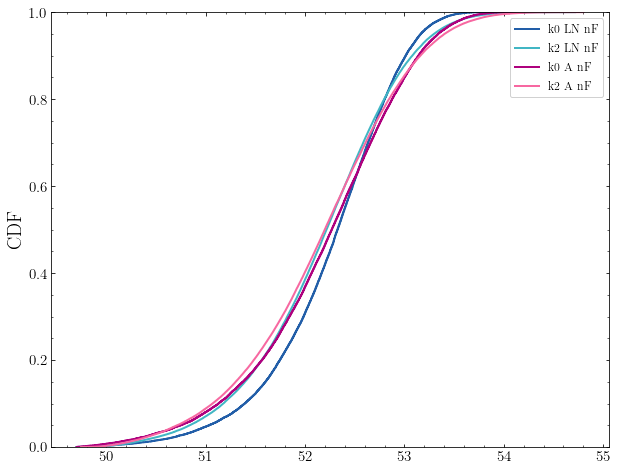

In [60]:
# All the things below are tests that didn't pan out
# Since just the redshift distribution of SHOALS doesn't help to discriminate much, maybe the L-z plane will
mod = 'k0_LN_nF'
cond = (dfs[mod]['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod][cond]['z'].to_numpy(),
               np.log10(dfs[mod][cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()



mod = 'k2_LN_nF'
cond = (dfs[mod]['erg_flnc_BAT']>=1e-7)
pf.cool_hist2d(dfs[mod][cond]['z'].to_numpy(),
               np.log10(dfs[mod][cond]['L'].to_numpy()),
               mode='hist2d', cb=False)
fig = plt.gcf()
axes = fig.axes
axes[0].set_xlim(0,7)
plt.show()

frac = np.zeros((len(size), len(flnc_cuts)))
k=0
# for i, j in product(range(len(size)), range(len(flnc_cuts))):
i=-1
j=-1
log.info("{} %. Size, fluence cut = {} {}".format(100*k/(len(size)*len(flnc_cuts)), size[i], flnc_cuts[j]))
frac[i,j]= st.subsample_and_KS(np.log10(dfs['k0_A_nF'][(dfs['k0_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])]),
                             np.log10(dfs['k2_A_nF'][(dfs['k2_A_nF']['erg_flnc_BAT']>=flnc_cuts[j])]),
                             key='pht_flnc_BAT',
                             precision=precision,
                             bins=np.linspace(-4,4,precision+1),
                             N_sub=size[i],
                             N_bs=100,
                             subsample2=False, show_plot=True)
log.info("Fraction of samples different at the 95% confidence level : {}".format(frac[i,j]))
k+=1
plt.gcf().axes[0].set_xlabel('log photon fluence [ph/cm$^2$]')

p_discr_L['A'] = frac

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT']),
                          key='S_BAT',
                          plot_obs=(i==0),
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the photon fluence distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these fluence distributions and the observed SHOALS fluence distribution
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod]['pht_flnc_BAT']),
                          key='S_BAT',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['pht_flnc_BAT'], df_obs['S_BAT'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

# Plot the luminosity distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
fig, ax = plt.subplots(figsize=(10,8))
df_obs = obs.read_SHOALS_file()
colors = ['#225ea8', '#41b6c4', '#ae017e', '#f768a1']
for i,mod in enumerate(model_names_ks):
    print(f"################# {mod} #####################")
    obs.plot_SHOALS_distr(np.log10(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['L']),
                          key='L',
                          plot_obs=False,
                          cumul=True,
                          fig=fig,
                          mod_color=colors[i],
                          mod_label=mod.replace('_',' '))
